In [1]:
from JupyterImport import *
from src.DataStandardize.ExpSpecific.Sep20 import Fixes
from src.DatObject.Attributes import SquareEntropy as SE, Transition as T, Entropy as E, DatAttribute as DA, Logs as L
root_logger.setLevel(logging.INFO)

In [13]:
# dat = get_dat(1244)  # Test dat with only 2 rows
dat = get_dat(1248)

Fixes._add_magy(dat)

INFO:src.DatObject.DatBuilder:No "AWG" added
INFO:src.DatObject.Attributes.Other:value of magy has type <class 'src.DatObject.Attributes.Logs.MAGs'> which is not allowed in HDF, will not be stored!


In [10]:
save_graphs = False
recalculate = False
if not hasattr(dat.Other, 'time_processed') or recalculate is True:
    bin_data = True
    num_per_row = 400

    sub_line = False

    allowed_amps = (0.8, 1.2)
    default_amp = 1.05
    allowed_dTs = (1.0, 15.1)
    default_dT = 4.7

    ys = dat.SquareEntropy.y
    z = dat.SquareEntropy.Processed.outputs.cycled

    xs, trans_datas, entropy_datas, integrated_datas = list(), list(), list(), list()
    tcs, ths, dTs, mids, amps, sfs = list(), list(), list(), list(), list(), list()
    fit_entropies, integrated_entropies = list(), list()

    for trans_data in z:
        x = dat.SquareEntropy.Processed.outputs.x
        entropy_data = SE.entropy_signal(trans_data)

        data_tcs, data_amps, data_centers = list(), list(), list()
        for data in trans_data[0::2]:
            fit = T.transition_fits(x, data, func=T.i_sense)[0]
            data_tcs.append(fit.best_values['theta'])
            data_amps.append(fit.best_values['amp'])
            data_centers.append(fit.best_values['mid'])

        data_ths = list()
        for data in trans_data[1::2]:
            fit = T.transition_fits(x, data, func=T.i_sense)[0]
            data_ths.append(fit.best_values['theta'])

        tc = np.nanmean(data_tcs)
        th = np.nanmean(data_ths)
        dT = th-tc


        amp = np.nanmean(data_amps)
        mid = np.average(data_centers)

        mid = mid if (-1000 < mid < 1000) else 0    
        if not (allowed_amps[0] < amp < allowed_amps[1]):
            amp = default_amp
        if not (allowed_dTs[0] < dT < allowed_dTs[1]):
            dT = default_dT
        dx = np.mean(np.diff(x))
        sf = SE.scaling(dt=dT, amplitude=amp, dx=dx)
        int_info = SE.IntegratedInfo(dT=dT, amp=amp, dx=dx)
        integrated_data = SE.integrate_entropy(entropy_data, int_info.sf)

        if sub_line is True:
            indexs = CU.get_data_index(x, [mid-2000, mid-500])
            line_fit = line.fit(integrated_data[indexs[0]:indexs[1]], x=x[indexs[0]:indexs[1]], nan_policy='omit')
            integrated_data = integrated_data-line_fit.eval(x=x)

        indexs = CU.get_data_index(x, [mid+600, mid+1000])
        int_dS = np.mean(integrated_data[indexs[0]:indexs[1]]) 

        # Calculate Nik Fit
        e_pars = E.get_param_estimates(x, entropy_data)[0]
        e_pars = CU.edit_params(e_pars, 'const', 0, False)
        efit = E.entropy_fits(x, entropy_data, params=e_pars)[0]
        efit_info = DA.FitInfo()
        efit_info.init_from_fit(efit)  

        if bin_data is True:
            bin_size = np.ceil(x.shape[-1]/num_per_row)
            trans_data = CU.bin_data(trans_data, bin_size)
            entropy_data = CU.bin_data(entropy_data, bin_size)
            integrated_data = CU.bin_data(integrated_data, bin_size)
            x = np.linspace(x[0], x[-1], int(x.shape[-1]/bin_size))

        tcs.append(tc)
        ths.append(th)
        dTs.append(dT)
        sfs.append(sf)
        xs.append(x)
        amps.append(amp)
        mids.append(mid)
        trans_datas.append(trans_data)
        entropy_datas.append([efit_info.eval_fit(x=x), entropy_data])
        integrated_datas.append(integrated_data)
        integrated_entropies.append(int_dS)
        fit_entropies.append(efit_info.best_values.dS)


    dat.Other.time_processed = str(pd.Timestamp.now())
    dat.Other.tcs = tcs
    dat.Other.ths = ths
    dat.Other.dTs = dTs
    dat.Other.amps = amps
    dat.Other.mids = mids
    dat.Other.sfs = sfs

    dat.Other.set_data('xs', np.asanyarray(xs))
    dat.Other.ys = ys[:]
    dat.Other.set_data('trans_datas', np.asanyarray(trans_datas))
    dat.Other.set_data('entropy_datas', np.asanyarray(entropy_datas))
    dat.Other.set_data('integrated_datas', np.asanyarray(integrated_datas))

    dat.Other.integrated_entropies = integrated_entropies
    dat.Other.fit_entropies = fit_entropies
    dat.Other.update_HDF()

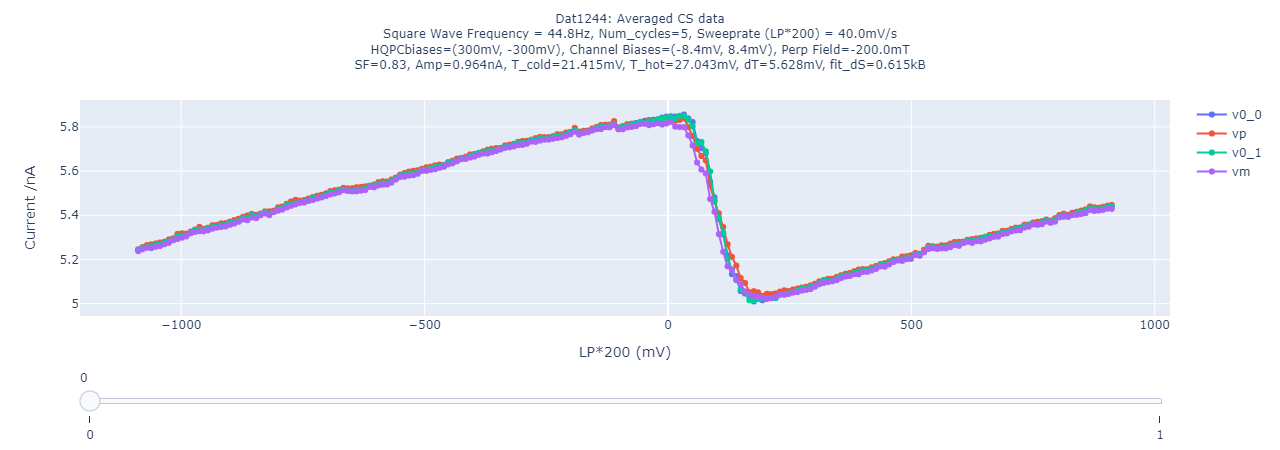

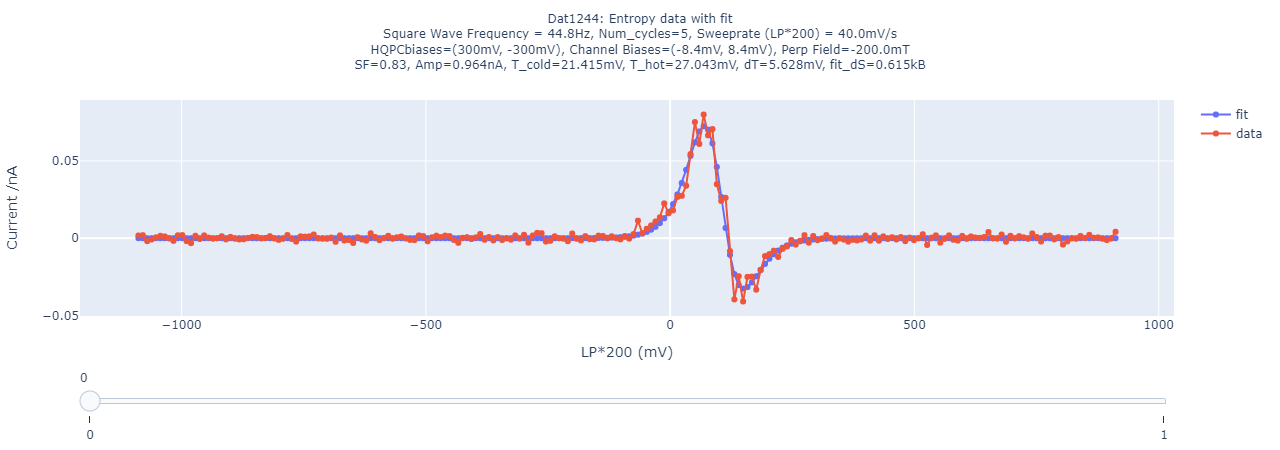

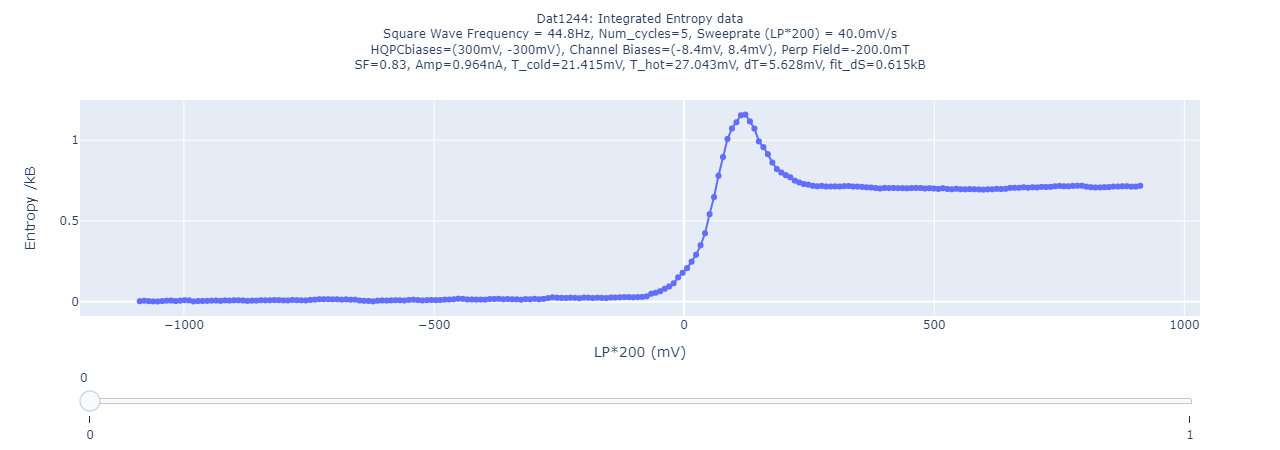

In [11]:
fig = go.Figure()    

ids, trans_titles, entropy_titles, integrated_titles = list(), list(), list(), list()
for y, tc, th, dT, dS, sf, amp in zip(dat.Other.ys, dat.Other.tcs, dat.Other.ths, dat.Other.dTs, dat.Other.fit_entropies, dat.Other.sfs, dat.Other.amps):
    scan_freq = dat.Logs.Fastdac.measure_freq/dat.AWG.info.wave_len
    fit_text = f'SF={sf:.2f}, Amp={amp:.3f}nA, T_cold={tc:.3f}mV, T_hot={th:.3f}mV, dT={dT:.3f}mV, fit_dS={dS:.3f}kB'
    scan_text = f'HQPCbiases=({dat.AWG.AWs[0][0][1]:.0f}mV, {dat.AWG.AWs[0][0][3]:.0f}mV), Channel Biases=({dat.AWG.AWs[1][0][1]:.1f}mV, {dat.AWG.AWs[1][0][3]:.1f}mV), Perp Field={dat.Other.magy.field:.1f}mT'
    array_text = f'Square Wave Frequency = {scan_freq:.1f}Hz, Num_cycles={dat.AWG.info.num_cycles}, Sweeprate (LP*200) = {dat.Logs.sweeprate:.1f}mV/s'
    text_info = f'{array_text}<br>{scan_text}<br>{fit_text}'
    trans_titles.append(f'Dat{dat.datnum}: Averaged CS data<br>{text_info}')
    entropy_titles.append(f'Dat{dat.datnum}: Entropy data with fit<br>{text_info}')
    integrated_titles.append(f'Dat{dat.datnum}: Integrated Entropy data<br>{text_info}')

xs = dat.Other.Data['xs']
trans_datas = [d for d in dat.Other.Data['trans_datas']]
entropy_datas = [d for d in dat.Other.Data['entropy_datas']]
integrated_datas = [d for d in dat.Other.Data['integrated_datas']]

    
fig1 = PlU.get_figure(datas=trans_datas, xs=xs, ids=ids, titles=trans_titles, labels=['v0_0', 'vp', 'v0_1', 'vm'], xlabel=f'{dat.Logs.x_label}', ylabel='Current /nA', plot_kwargs={'mode':'lines+markers'})
fig2 = PlU.get_figure(datas=entropy_datas, xs=xs, ids=ids, titles=entropy_titles, labels=['fit', 'data'], xlabel=f'{dat.Logs.x_label}', ylabel='Current /nA', plot_kwargs={'mode':'lines+markers'})
fig3 = PlU.get_figure(datas=integrated_datas, xs=xs, ids=ids, titles=integrated_titles, xlabel=f'{dat.Logs.x_label}', ylabel='Entropy /kB', plot_kwargs={'mode':'lines+markers'})

for fig, name in zip([fig1, fig2, fig3], ['AveragedCS_vs_Channel_bias', 'Average_Entropy_With_Fit', 'Averaged_Integrated_Entropy']):
    fig.update_layout(hovermode = 'x unified',
                     title=dict(y=0.95,x=0.5,xanchor='center',yanchor='top', font=dict(size=12)))
    if save_graphs: 
        fig.write_html(export_path+f'Dat{dat.datnum}--{name}.html')
    fig.show()

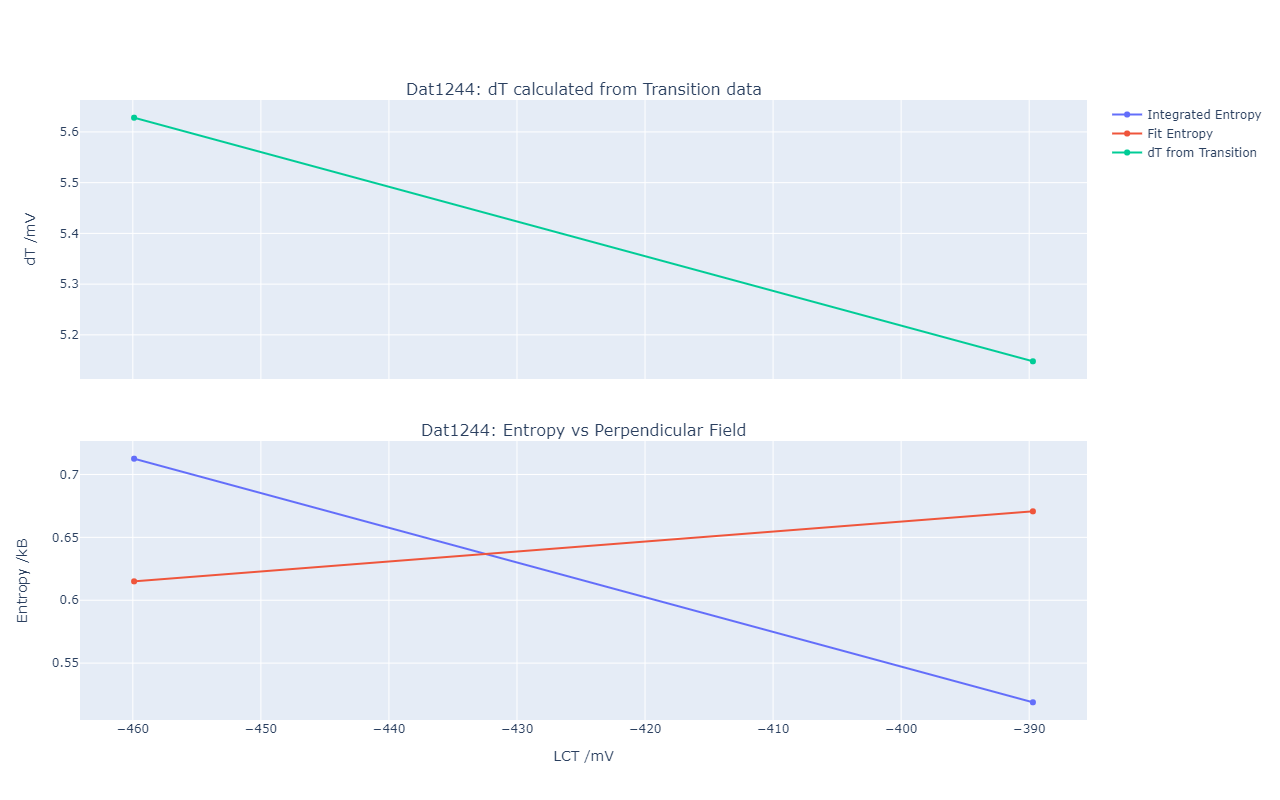

In [12]:
save_graphs = save_graphs

x = dat.Other.ys
dTs = dat.Other.dTs
integrated_entropies = dat.Other.integrated_entropies
fit_entropies = dat.Other.fit_entropies

# hover_template1 = base_hover_template + 'dT:%{y:.2f}mV'
# hover_template2 = base_hover_template + 'Entropy:%{y:.2f}kB'
title1 = f'Dat{dat.datnum}: dT calculated from Transition data'
title2 = f'Dat{dat.datnum}: Entropy vs Perpendicular Field'
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1, subplot_titles=[title1, title2])

for data, name in zip([integrated_entropies, fit_entropies], ['Integrated Entropy', 'Fit Entropy']):
    fig.add_trace(go.Scatter(mode='markers+lines', x=x, y=data, name=name), row=2, col=1)
fig.add_trace(go.Scatter(yaxis='y2', name='dT from Transition', x=x, y=dTs, mode='markers+lines'), row=1, col=1)

fig.update_traces(textposition='top center')
fig.update_layout(xaxis2_title='LCT /mV', height=800)
for label, row in zip(['dT /mV', 'Entropy /kB'], [1, 2]):
    fig.update_yaxes(title_text=label, row=row, col=1)
fig.show()

if save_graphs:
    fig.write_html(export_path+f"Dats{dats[0].datnum}-{dats[-1].datnum}--Entropy vs Field with dT.html")